# Animal Identifier

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

#Path
from pathlib import Path
import os.path

import sys
sys.path.append("./red/images")
import translate

# Metrics
from sklearn.metrics import classification_report, confusion_matrix



from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf


ModuleNotFoundError: No module named 'tensorflow'

In [3]:
print(tf.__version__)

2.18.0


### Accesing docs

In [ ]:
p = Path('.')
[x for x in p.iterdir() if x.is_dir()]

[PosixPath('.nv'),
 PosixPath('.landscape'),
 PosixPath('.pymol'),
 PosixPath('.conda'),
 PosixPath('__pycache__'),
 PosixPath('fragpipe'),
 PosixPath('.cache'),
 PosixPath('anaconda3'),
 PosixPath('.java'),
 PosixPath('.keras'),
 PosixPath('.config'),
 PosixPath('DNA_Python_Diego_Sanchez'),
 PosixPath('.jupyter'),
 PosixPath('.vscode-R'),
 PosixPath('.miktex'),
 PosixPath('.dotnet'),
 PosixPath('.anaconda'),
 PosixPath('NJ_PhylogeneticTREE'),
 PosixPath('.local'),
 PosixPath('bin'),
 PosixPath('.boltz'),
 PosixPath('.vscode-server'),
 PosixPath('.ipython')]

In [ ]:
p = Path('./red')
list_animal=[];list_iter=[]
for child in p.iterdir(): 
    if child.parts[-1] == "images":
        print(child)
        prt=child.iterdir()
        for i in prt:
            if "raw-img" in i.parts:
                for child2 in Path('./red/images/raw-img').iterdir():
                    print(child2.parts[-1])
                    list_iter.append(child2.parts[-1])
                    list_animal.append(translate.translate[child2.parts[-1]])
                    

/mnt/c/Users/elotr/Desktop/red/images
cane
cavallo
elefante
farfalla
gallina
gatto
mucca
pecora
ragno
scoiattolo


### Create df

In [ ]:
from PIL import Image
from tqdm import tqdm
pth=[];lab=[]
for i in list_iter:
    for child in tqdm(Path('./red/images/raw-img/'+str(i)).iterdir()):
        if len(np.asarray(Image.open(str(child))).shape) == 3 and np.asarray(Image.open(str(child))).shape[-1] ==3:
            pth.append(str(child))
            lab.append(str(translate.translate[i]))
        
data_df=pd.DataFrame([pth, lab])
data_df= data_df.transpose()
data_df.columns=["Path","Label"]
data_df

212it [00:02, 85.03it/s]


KeyboardInterrupt: 

In [ ]:
data_df.dtypes

Path     object
Label    object
dtype: object

In [ ]:
data_df["Label"].value_counts()

Label
dog          4863
spider       4820
chicken      3098
horse        2623
butterfly    2073
cow          1866
squirrel     1862
sheep        1820
cat          1667
elephant     1436
Name: count, dtype: int64

In [ ]:
data_df.loc[data_df["Label"]=="dog", "Path"].head()

0    /mnt/c/Users/elotr/Desktop/red/images/raw-img/...
1    /mnt/c/Users/elotr/Desktop/red/images/raw-img/...
2    /mnt/c/Users/elotr/Desktop/red/images/raw-img/...
3    /mnt/c/Users/elotr/Desktop/red/images/raw-img/...
4    /mnt/c/Users/elotr/Desktop/red/images/raw-img/...
Name: Path, dtype: object

### Visualize random images

In [ ]:
data_df.iloc[0,0]

'/mnt/c/Users/elotr/Desktop/red/images/raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg'

Text(0.5, 1.0, 'dog')

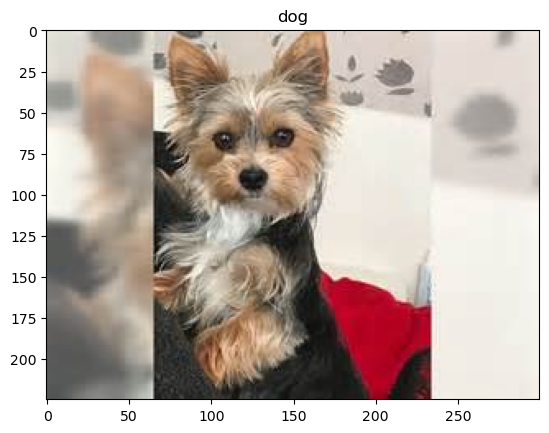

In [ ]:
from PIL import Image
img = np.asarray(Image.open(data_df.iloc[0,0]))
plt.imshow(img)
plt.title("dog")


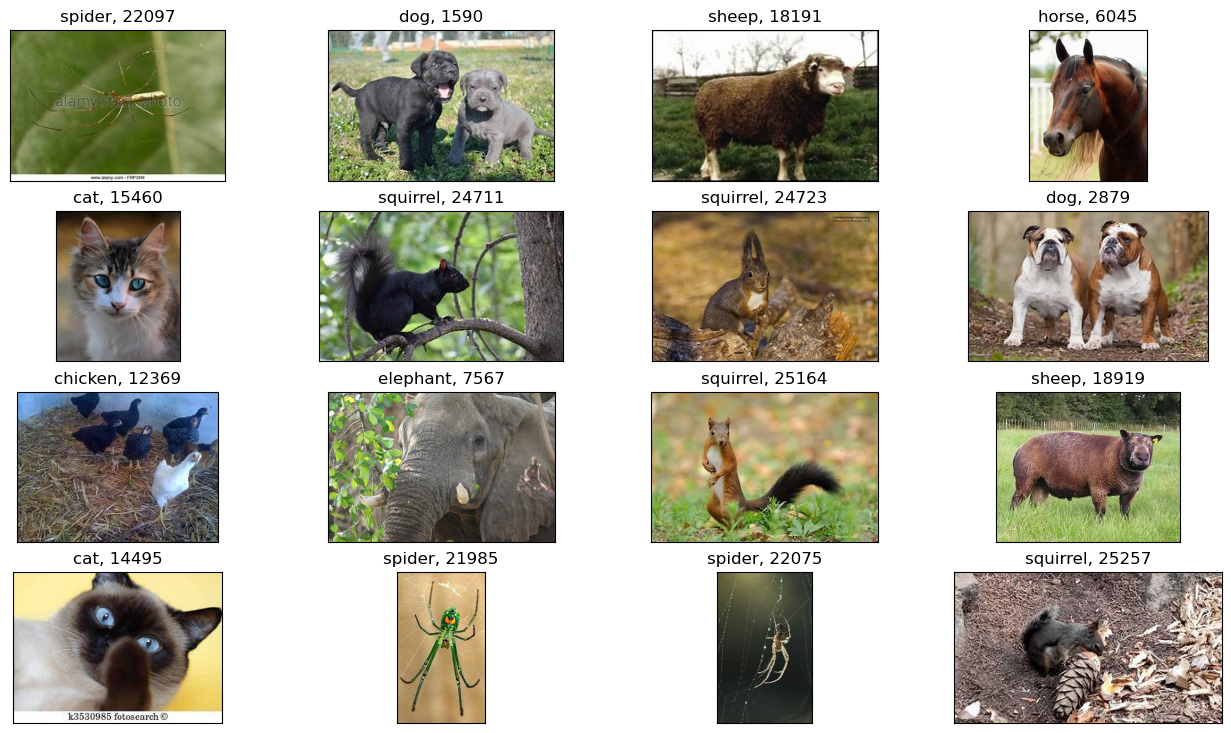

In [ ]:
from tqdm import tqdm
max_ax=4
numbers=random.sample(range(26000),k=max_ax**2)
fig, axs = plt.subplots(max_ax, max_ax, figsize=(16,9))
iteration = 1
num=0
while True:
    for i in range(0, max_ax):
        img = np.asarray(Image.open(data_df.iloc[numbers[num],0]))
        labl= data_df.iloc[numbers[num],1]
        axs[i, iteration-1].imshow(img)
        axs[i, iteration-1].set_title(str(labl)+", "+str(numbers[num]))
        axs[i, iteration-1].set_xticks([])
        axs[i, iteration-1].set_yticks([])
        num=num+1
    iteration = iteration +1
    if iteration > max_ax:
        break
        


# Model

In [ ]:
def ResNet50(input_shape = (224, 224, 3), classes = len(list_iter), training=False):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
#tf.keras.backend.set_learning_phase(True)

model = ResNet50(input_shape = (224, 224, 3), classes = len(list_iter))
print(model.summary())

I0000 00:00:1757609764.510283   32594 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9709 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:09:00.0, compute capability: 8.6
W0000 00:00:1757609766.032835   34443 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/dsanchezg/anaconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/dsanchezg/anaconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/dsanchezg/anaconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 230, 230, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 193600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │     1,936,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,945,738 (7.42 MB)

 Trainable params: 1,945,610 (7.42 MB)

 Non-trainable params: 128 (512.00 B)

None


In [ ]:
np.random.seed(1)
tf.random.set_seed(2)
opt = tf.keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Preprocess

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_df.iloc[:,0], data_df.iloc[:,1], test_size=0.25, random_state=13)

In [ ]:
l=[]
a=np.array(tf.image.resize(np.asarray(Image.open(X_train[0])), [224,224], method='nearest'))
l.append(a)

In [ ]:
b=np.array(tf.image.resize(np.asarray(Image.open(X_train[1])), [224,224], method='nearest'))
l.append(b)

In [ ]:
v=np.array(l)
v.shape

(2, 224, 224, 3)

In [ ]:
import tensorflow as tf
from tqdm import tqdm
X_tr=[]
X_tst=[]
for i in tqdm(X_train):
    ni = tf.image.resize(np.asarray(Image.open(i)), [224,224], method='nearest')
    X_tr.append(np.array(ni))
    
for j in tqdm(X_test):
    nj = tf.image.resize(np.asarray(Image.open(j)), [224,224], method='nearest')
    X_tst.append(np.array(nj))

X_train_fin=np.array(X_tr)
X_test_fin=np.array(X_tst)

100%|██████████| 6532/6532 [00:49<00:00, 132.44it/s]


: 

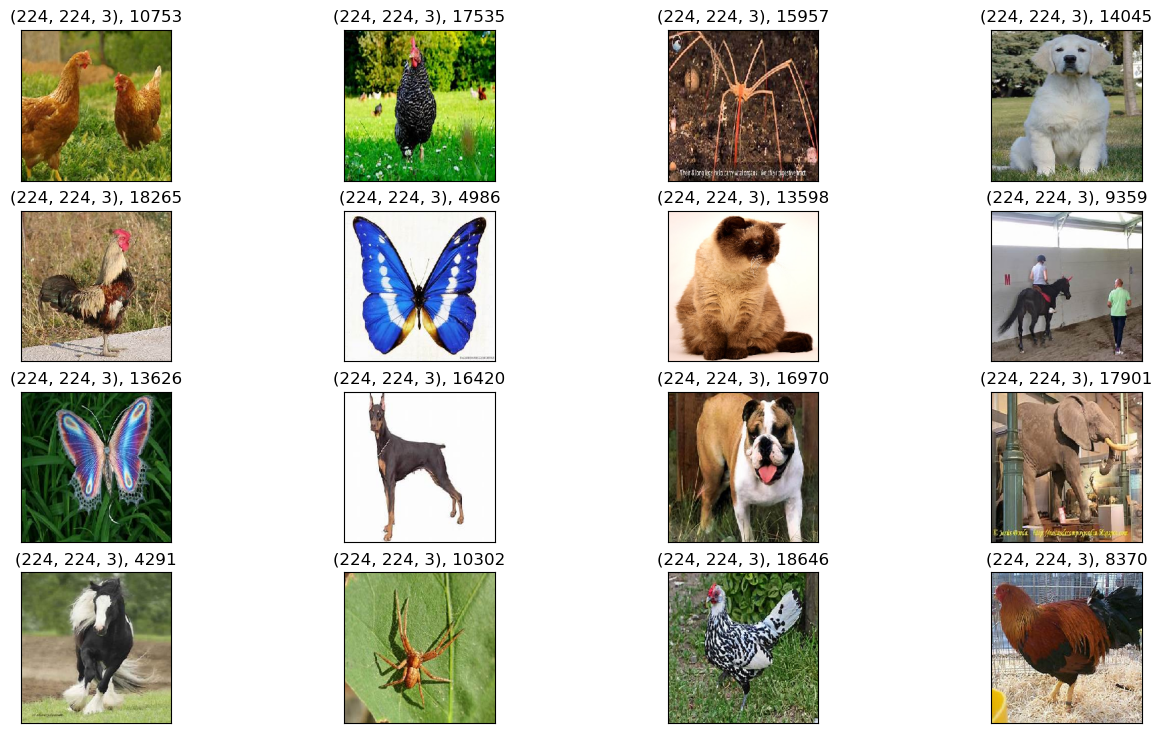

In [ ]:
max_ax=4
numbers=random.sample(range(19000),k=max_ax**2)
fig, axs = plt.subplots(max_ax, max_ax, figsize=(16,9))
iteration = 1
num=0
while True:
    for i in range(0, max_ax):
        img = X_tr[numbers[num]]
        axs[i, iteration-1].imshow(img)
        axs[i, iteration-1].set_title(str(X_tr[numbers[num]].shape)+", "+str(numbers[num]))
        axs[i, iteration-1].set_xticks([])
        axs[i, iteration-1].set_yticks([])
        num=num+1
    iteration = iteration +1
    if iteration > max_ax:
        break

In [ ]:
#one-hot
list_iter
Y_tr=[]
Y_tst=[]
for i in tqdm(Y_train):
    n=[0]*len(list_animal)
    idx=list_animal.index(i)
    n[idx]=1
    Y_tr.append(n)

for i in tqdm(Y_test):
    n=[0]*len(list_animal)
    idx=list_animal.index(i)
    n[idx]=1
    Y_tst.append(n)  
    
Y_train_fin=np.array(Y_tr)
Y_test_fin=np.array(Y_tst)

NameError: name 'list_iter' is not defined

In [ ]:
print(X_train_fin.shape)
print(X_test_fin.shape)
print(Y_train_fin.shape)
print(Y_test_fin.shape)

2025-09-11 18:20:26.174294: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2949746688 exceeds 10% of free system memory.


In [ ]:
#model.fit(tf.convert_to_tensor(X_tr), tf.convert_to_tensor(Y_tr), epochs = 10, batch_size = 32)

2025-09-11 17:45:33.212962: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2955316224 exceeds 10% of free system memory.
2025-09-11 17:45:33.215728: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Shapes of all inputs must match: values[0].shape = [224,224,3] != values[302].shape = [224,224,4]


InvalidArgumentError: {{function_node __wrapped__Pack_N_19633_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [224,224,3] != values[302].shape = [224,224,4] [Op:Pack] name: packed